In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

┌ Info: Precompiling ReactiveMPPaperExperiments [adcd1038-27e6-4580-819b-caa5dba07e45]
└ @ Base loading.jl:1342
┌ Warning: Package ReactiveMPPaperExperiments does not have ReactiveMP in its dependencies:
│ - If you have ReactiveMPPaperExperiments checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMPPaperExperiments
└ Loading ReactiveMP into ReactiveMPPaperExperiments from project dependency, future warnings for ReactiveMPPaperExperiments are suppressed.


In [13]:
using ReactiveMP, Rocket, GraphPPL, Distributions, Random
using CairoMakie
using BenchmarkTools, DataFrames, Query, LinearAlgebra

import ReactiveMP: update!

### Multivariate Gaussian Mixture Estimation

In this example we are going to run inference on multivariate gaussian mixture model with ReactiveMP.jl.

The observations in this model are i.i.d., but the model itself shares the same parameters across all mixture components. It can be described in the following way:

$$
\begin{equation}
  \begin{aligned}
	z_i & \sim \, \text{Bernoulli}(\pi)\\	
	y_i & \sim \, \prod_{k = 1}^{N}\mathcal{N}(\bf{m}_k, \bf{W^{-1}}_k)^{z_{i}^{(k)}}
  \end{aligned}
\end{equation}
$$

All model parameters are also endowed with priors:

$$
\begin{equation}
  \begin{aligned}
	\pi & \sim \, \text{Beta}(1, 1)\\	
	\bf{m}_k & \sim \, \mathcal{N}(\bf{m}_k^{(0)}, \bf{W^{-1}}_k^{(0)}) \\
	\bf{W}_k & \sim \, \text{Wishart}(\text{d\,}_k^{(0)}, \bf{S}_k^{(0)})
  \end{aligned}
\end{equation}
$$

### Syntethic data

First lets generate some synthetic data. We will generate some samples from real Gaussian Mixture distribution with the help of the `Distributions.jl` package.

In [4]:
params = let
    # Seed for reproducability
    seed = 42
    
    # Number of IID samples
    n = 500
    
    # Number of mixture components
    nmixtures = 6
    
    # Mixture component mean distance from zero
    cdistance = 10
    
    # Angle change rate
    angle = 1.5π / nmixtures
    
    # Number of VMP iterations (for inference)
    niters = 10
    
    @strdict seed n nmixtures cdistance angle niters
end;

In [5]:
y = generate_data(GMMModel(), params);

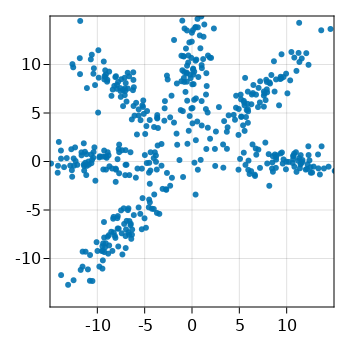

In [6]:
let
    @unpack seed, nmixtures, cdistance, angle, n = params
    
    sdim    = (n) -> (a) -> map(d -> d[n], a)
    limits  = (-1.5cdistance, 1.5cdistance)

    fig = Figure(resolution = (350, 350))
    ax = Makie.Axis(fig[1, 1])

    ax.xticks = [ -10, -5, 0, 5, 10 ]
    ax.yticks = [ -10, -5, 0, 5, 10 ]

    xlims!(ax, limits)
    ylims!(ax, limits)

    palette = fig.scene.palette.color[]

    scatter!(ax, 
        y |> sdim(1), y |> sdim(2), 
        markersize = 6, color = (palette[1], 0.9), 
        label = "Observations"
    )

    @saveplot fig "gmm_data"
end

### Model specification

GraphPPL.jl offers a model specification syntax that resembles closely to the mathematical equations defined above. `datavar` placeholders are used to indicate variables that take specific values at a later date. For example, the way we feed observations into the model is by iteratively assigning each of the observations in our dataset to the data variables `y`.

We also use a mean-field factorisation by default for all parameters in our model.

In [7]:
# We use mean field factorisation by default for Gaussian Mixture estimation
@model [ default_factorisation = MeanField() ] function gaussian_mixture_model(nmixtures, nsamples)
    
    z = randomvar(nsamples)
    m = randomvar(nmixtures) # A sequence of random variables for means
    w = randomvar(nmixtures) # A sequence of random variables for precision
    y = datavar(Vector{Float64}, nsamples) # A sequence of observed samples
    
    # We set uninformative priors for means and precisions
    for i in 1:nmixtures
        m[i] ~ MvGaussianMeanCovariance(zeros(2), [ 1e6 0.0; 0.0 1e6 ])
        w[i] ~ Wishart(2, [ 1e5 0.0; 0.0 1e5 ])
    end
    
    # Use uninformative prior for switching distribution
    s ~ Dirichlet(ones(nmixtures))
    
    # GaussianMixture node accepts means and precisions arguments in a form of tuple
    means = tuple(m...)
    precs = tuple(w...)
    
    # For each sample assign a switch ditribution to be Categorical and
    #  connect observed sample to a GaussianMixture node
    for i in 1:nsamples
        z[i] ~ Categorical(s)
        y[i] ~ GaussianMixture(z[i], means, precs)
    end
    
    return s, z, m, w, y
end

gaussian_mixture_model (generic function with 1 method)

# Inference

Next we need to define our inference procedure. Since we used mean field factorisation we need to perform some VMP iterations. To do so we pass same data to `update!` function multiple times forcing inference backend to react multiple times and hence update posterior marginals of the model parameters.

To actually start VMP procedure we need initial marginals. We use `setmarginal!` function to define an initial marginal for the model parameters. We decouple initial marginals to avoid collapsing of clusters and to improve procedure convergence rate.

In [8]:
function inference(data, params)
    @unpack seed, nmixtures, cdistance, angle, niters = params
    
    n = length(data)
    
    # First we create a model based on the number of observations 
    # we have in our dataset
    model, (s, z, m, w, y) = gaussian_mixture_model(nmixtures, n)

    # Some preallocated buffers for our results
    means_estimates  = buffer(Marginal, nmixtures)
    precs_estimates  = buffer(Marginal, nmixtures)
    mixing_estimate  = nothing
    fe_values        = ScoreActor(Float64)

    # General receipt is to subscribe on marginals of interests
    # and to store them in some buffer for later analysis
    switchsub = subscribe!(getmarginal(s), (m) -> mixing_estimate = m)
    meanssub  = subscribe!(getmarginals(m), means_estimates)
    precssub  = subscribe!(getmarginals(w), precs_estimates)
    fesub     = subscribe!(score(Float64, BetheFreeEnergy(), model), fe_values)

    # We use `setmarginal!` function to set initial marginals for VMP procedure
    setmarginal!(s, vague(Dirichlet, nmixtures))

    # We decouple initial marginals to avoid collapsing of clusters
    basis_v = [ 1.0, 0.0 ]
    for i in 1:nmixtures
        angle_prior = angle * (i - 1)
        mean_mean_prior = [ 
            cos(angle_prior) -sin(angle_prior); 
            sin(angle_prior) cos(angle_prior) 
        ] * basis_v
        mean_mean_cov   = [ 1e6 0.0; 0.0 1e6 ]

        setmarginal!(m[i], MvNormalMeanCovariance(mean_mean_prior, mean_mean_cov))
        setmarginal!(w[i], Wishart(2, [ 1e3 0.0; 0.0 1e3 ]))
    end

    # We pass data multiple times to force inference engine to react multiple times
    # and hence update posterior marginals multiple times
    for i in 1:niters
        update!(y, data)
    end

    # In general, it is always better to unsubscribe 
    # at the end of the inference procedure
    unsubscribe!(switchsub)
    unsubscribe!(meanssub)
    unsubscribe!(precssub)
    unsubscribe!(fesub)

    return (
        getvalues(means_estimates),
        getvalues(precs_estimates),
        mixing_estimate,
        getvalues(fe_values)
    )
end

inference (generic function with 1 method)

In [10]:
means_estimated, precs_estimated, mixing_estimated, fe = inference(y, params);

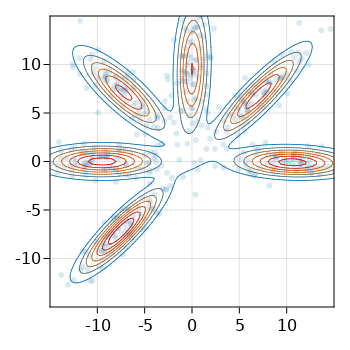

In [14]:
let
    @unpack seed, nmixtures, cdistance, angle, niters = params
    
    sdim    = (n) -> (a) -> map(d -> d[n], a)
    limits  = (-1.5cdistance, 1.5cdistance)
    sigmoid = (x) -> 1 / (1 + exp(-x))

    fig = Figure(resolution = (350, 350))
    ax = Makie.Axis(fig[1, 1])

    ax.xticks = [ -10, -5, 0, 5, 10 ]
    ax.yticks = [ -10, -5, 0, 5, 10 ]

    xlims!(ax, limits)
    ylims!(ax, limits)

    palette = fig.scene.palette.color[]

    scatter!(ax, 
        y |> sdim(1), y |> sdim(2), 
        markersize = 6, color = (palette[1], 0.15), 
        label = "Observations"
    )

    e_means = mean.(means_estimated)
    e_precs = mean.(precs_estimated)
    crange  = range(-2cdistance, 2cdistance, step = 0.25)
    mixing  = mean(mixing_estimated)

    mixture = Distributions.MixtureModel(
        map(e -> MvNormal(e[1], Matrix(Hermitian(inv(e[2])))), zip(e_means, e_precs)),
        mixing
    )

    c = Makie.wong_colors()

    cobj = contour!(ax, 
        crange, crange, (x, y) -> pdf(mixture, [ x, y ]), 
        levels = 7, colorbar = true, linewidth = 0.8, overdraw = true,
        colormap = cgrad([ c[1], c[6], :red3 ])
    )

    # Colorbar(fig[1, 2], cobj)

    @saveplot fig "gmm_inference"
end

As we can see our model correctly predicted the underlying means and precisions for the actual mixture components in our gaussian mixture distribution.

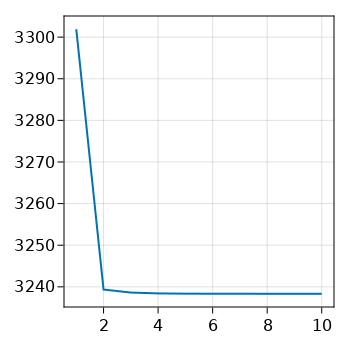

In [15]:
let
    fig = Figure(resolution = (350, 350))
    ax  = Makie.Axis(fig[1, 1])

    lines!(ax, 1:length(fe), fe, linewidth = 2)

    @saveplot fig "gmm_fe"
end

In [35]:
function run_benchmark(params)
    @unpack n, niters, seed, nmixtures, cdistance, angle = params

    y = generate_data(GMMModel(), params);

    ms, ps, mixing, fe = inference(y, params);
    benchmark = @benchmark inference($y, $params);

    output = @strdict n niters seed nmixtures cdistance angle ms ps mixing fe benchmark

    return output
end


run_benchmark (generic function with 1 method)

In [36]:
# Here we create a list of parameters we want to run our benchmarks with
benchmark_params = dict_list(Dict(
    "n"      => [ 50, 100, 250, 500, 750, 1000, 1500, 2000 ],
    "niters" => [ 5, 10, 15 ],
    "seed"   => 42,
    "nmixtures" => [ 4, 5, 6 ],
    "cdistance" => 10,
    "angle"     => 1.5π / 6
));


In [37]:
gmm_benchmarks = map(benchmark_params) do params
    path = datadir("benchmark", "gmm", "rmp")
    result, _ = produce_or_load(path, params; tag = false) do p
        run_benchmark(p)
    end
    return result
end;

┌ Info: File /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/gmm/rmp/angle=0.785_cdistance=10_n=50_niters=5_nmixtures=4_seed=42.jld2 does not exist. Producing it now...
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/Kwvgi/src/saving_files.jl:61
┌ Info: File /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/gmm/rmp/angle=0.785_cdistance=10_n=50_niters=5_nmixtures=4_seed=42.jld2 saved.
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/Kwvgi/src/saving_files.jl:70
┌ Info: File /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/gmm/rmp/angle=0.785_cdistance=10_n=50_niters=5_nmixtures=5_seed=42.jld2 does not exist. Producing it now...
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/Kwvgi/src/saving_files.jl:61
┌ Info: File /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/gmm/rmp/angle=0.785_cdistance=10_n=50_niters=5_nmixtures=5_seed=42.jld2 saved.
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWa

In [24]:
target_seed = 42
target_niters = 15
target_nmixtures = 6

6

In [30]:
let
    path_smoothing = datadir("benchmark", "gmm", "rmp")

    white_list   = [ "n", "niters", "seed", "nmixtures" ]
    special_list = [
        :min => (data) -> string(
            round(minimum(data["benchmark"]).time / 1_000_000, digits = 2), "ms"
        ),
        :mean => (data) -> string(
            round(mean(data["benchmark"]).time / 1_000_000, digits = 2), "ms"
        ),
        :gctime => (data) -> string(
            round(minimum(data["benchmark"]).gctime / minimum(data["benchmark"]).time * 100, digits = 2), "%"
        )
    ]

    df_smoothing = collect_results(path_smoothing, 
        white_list = white_list,
        special_list = special_list,
        verbose = false
    )

    query_smoothing = @from row in df_smoothing begin
        @where row.seed == target_seed && row.niters == target_niters && row.nmixtures == target_nmixtures
        @orderby ascending(row.n)
        @select { row.n, row.min, row.gctime }
    end

    DataFrame(query_smoothing)
end

┌ Info: Scanning folder /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/gmm/rmp for result files.
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/Kwvgi/src/result_collection.jl:88


,n,min,gctime
,Int64?,String?,String?
1,50,85.26ms,0.0%
2,100,200.76ms,10.8%
3,250,540.4ms,15.59%
4,500,1187.94ms,18.96%
5,750,1759.66ms,18.65%
6,1000,2473.32ms,20.14%
7,1500,3772.04ms,21.42%
8,2000,5293.36ms,25.34%
